In [1]:
target = "data/bay/0001.jpeg"

In [2]:
from imageio import imread
import numpy as np
from skimage import color, filters, img_as_float
import math

In [3]:
img = img_as_float(imread(target))

In [4]:
img.shape

(386, 687, 3)

In [5]:
tile_w = int(img.shape[0]/5)
tile_h = int(img.shape[1]/5)

In [6]:
tile_w, tile_h

(77, 137)

In [7]:
tile = img[0:tile_w, 0:tile_h, :]

In [8]:
tile.shape

(77, 137, 3)

# Color Moments

In [9]:
def calc_moment3(arr, moment1):
    cubed = np.mean((tile[:, :, 0]-moment1)**3)
    return math.pow(abs(cubed),1/3) * (1,-1)[cubed<0]

In [10]:
def calc_moments(arr):
    moment1 = np.mean(arr)
    moment2 = np.mean((arr-moment1)**2)**(1/2)
    moment3 = calc_moment3(arr, moment1)
    return moment1, moment2, moment3

In [13]:
def calc_4_moments(rgbarr):
    r1, r2, r3 = calc_moments(rgbarr[:, :, 0])
    g1, g2, g3 = calc_moments(rgbarr[:, :, 1])
    b1, b2, b3 = calc_moments(rgbarr[:, :, 2])
    gray = color.rgb2gray(rgbarr)
    gr1, gr2, gr3 = calc_moments(gray)
    return [r1, r2, r3, g1, g2, g3, b1, b2, b3, gr1, gr2, gr3]

In [14]:
calc_4_moments(tile)

[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.2781541238099151,
 0.8166978005535328,
 0.05321479042159858,
 -0.4683674599313368,
 0.5731654929470128,
 0.073980597551597832,
 -0.2485871934295749]

# DOOG filter


Based on "Preattentive texture discrimination with early vision mechanisms", Fig. 2.

In [87]:

def G(y0, sigmax, sigmay, x, y):
    # The definition of G seems wrong, I refer original Yang's paper.
    # return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (x**2) + (y- y0/sigmay)**2)
    dimx = len(x)
    dimy = len(y)
    return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (1/2) * (((x/sigmax)**2).reshape(1, dimx) + (((y- y0)/sigmay)**2).reshape(dimy, 1)))

In [73]:
len(np.arange(5))

5

In [54]:
np.arange(0, 5)**2

array([ 0,  1,  4,  9, 16])

In [61]:
np.arange(5).reshape(5, 1)

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [62]:
arr =np.arange(5).reshape(5, 1)

In [66]:
arr[2][0]

2

In [71]:
arr2 =np.arange(5, 10).reshape(1, 5)

In [72]:
arr2+arr

array([[ 5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 12],
       [ 9, 10, 11, 12, 13]])

In [88]:
gausres = G(0, 2, 2, np.arange(5), np.arange(5))

In [89]:
gausres

array([[ 0.03978874,  0.03511344,  0.02413309,  0.01291751,  0.00538482],
       [ 0.03511344,  0.0309875 ,  0.02129738,  0.01139966,  0.00475209],
       [ 0.02413309,  0.02129738,  0.01463746,  0.00783487,  0.00326606],
       [ 0.01291751,  0.01139966,  0.00783487,  0.0041937 ,  0.0017482 ],
       [ 0.00538482,  0.00475209,  0.00326606,  0.0017482 ,  0.00072876]])

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

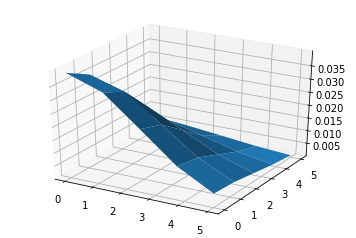

In [90]:

X,Y=np.meshgrid(np.linspace(0,5,5),np.linspace(0,5,5));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, gausres)
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [91]:
def DOOG2(x, y, sigma, r=3):
    sigmay = sigma
    sigmax = r*sigma
    ya = sigma
    yc = -sigma
    return -G(ya, sigmax, sigmay, x, y) + 2*G(0, sigmax, sigmay, x, y) - G(yc, sigmax, sigmay, x, y)

In [92]:
DOOG2(np.arange(0, 5), np.arange(0, 5), 4, 2)

array([[ 0.00391391,  0.00388345,  0.00379349,  0.00364817,  0.00345402],
       [ 0.0036098 ,  0.00358171,  0.00349874,  0.0033647 ,  0.00318564],
       [ 0.00277449,  0.0027529 ,  0.00268913,  0.00258611,  0.00244848],
       [ 0.00161234,  0.0015998 ,  0.00156274,  0.00150287,  0.00142289],
       [ 0.00038658,  0.00038357,  0.00037468,  0.00036033,  0.00034115]])

In [93]:
def DOOG2_weight(sigma, r=3, truncate=4):
    # similar filter size logic as filters.gaussian of scipy.
    lw = int(truncate * sigma + 0.5)
    return DOOG2(np.arange(0, lw), np.arange(0, lw), sigma, r)

In [94]:
DOOG2_weight(7.5)

array([[  7.42193665e-04,   7.41460996e-04,   7.39267326e-04,
          7.35625622e-04,   7.30557356e-04,   7.24092289e-04,
          7.16268185e-04,   7.07130443e-04,   6.96731655e-04,
          6.85131104e-04,   6.72394203e-04,   6.58591880e-04,
          6.43799917e-04,   6.28098268e-04,   6.11570333e-04,
          5.94302228e-04,   5.76382041e-04,   5.57899096e-04,
          5.38943215e-04,   5.19604010e-04,   4.99970194e-04,
          4.80128923e-04,   4.60165184e-04,   4.40161224e-04,
          4.20196023e-04,   4.00344835e-04,   3.80678768e-04,
          3.61264441e-04,   3.42163682e-04,   3.23433306e-04],
       [  7.25531014e-04,   7.24814793e-04,   7.22670373e-04,
          7.19110427e-04,   7.14155946e-04,   7.07836023e-04,
          7.00187575e-04,   6.91254980e-04,   6.81089650e-04,
          6.69749538e-04,   6.57298588e-04,   6.43806134e-04,
          6.29346259e-04,   6.13997121e-04,   5.97840247e-04,
          5.80959819e-04,   5.63441951e-04,   5.45373958e-04,
       

In [95]:
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html
from scipy.ndimage.filters import convolve

In [96]:
weights = DOOG2_weight(7.5)

In [98]:
weights.shape

(30, 30)

In [100]:
convolve(tile[:, :, 0], weights)

array([[ 0.00700563,  0.00698895,  0.00697538, ...,  0.00587873,
         0.00588779,  0.00589131],
       [ 0.00731609,  0.00730201,  0.00729126, ...,  0.00628678,
         0.00629372,  0.00629324],
       [ 0.00748217,  0.00747107,  0.00746349, ...,  0.00663851,
         0.0066426 ,  0.00664045],
       ..., 
       [-0.00970754, -0.00968341, -0.00965325, ..., -0.00225931,
        -0.00229642, -0.00232644],
       [-0.00748642, -0.00748114, -0.00747075, ..., -0.00221456,
        -0.00224807, -0.00226993],
       [-0.00506333, -0.00510153, -0.00513819, ..., -0.00228135,
        -0.00231105, -0.00232822]])

# Try and Error

In [11]:
calc_moments(tile[:, :, 0])

(0.37209400017472155, 0.10217063437619424, -0.09780083132038393)

In [21]:
color.rgb2gray(tile[0:3, 0:3, :])

array([[ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51777176,  0.51777176,  0.51777176]])

In [26]:
tmp = tile[0:3, 0:3, :]

In [27]:
[calc_moments(tmp[:, :, i]) for i in range(3)]

[(0.25882352941176467, 0.0055459355387180269, 0.15959603823333823),
 (0.56470588235294117, 0.0, -0.241661910774848),
 (0.78954248366013069, 0.0018486451795726665, -0.44268744485027073)]

In [28]:
len(calc_4_moments(tmp))

12

In [29]:
calc_4_moments(tile)

[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.2781541238099151,
 0.8166978005535328,
 0.05321479042159858,
 -0.4683674599313368,
 0.5731654929470128,
 0.073980597551597832,
 -0.2485871934295749]

In [19]:
def gray_arr(rgbarr):
    return (rgbarr[:, :, 0]+rgbarr[:, :, 1]+rgbarr[:, :, 2])/3

In [20]:
gray_arr(tile[0:3, 0:3, :])

array([[ 0.53594771,  0.53594771,  0.53594771],
       [ 0.53594771,  0.53594771,  0.53594771],
       [ 0.54117647,  0.54117647,  0.54117647]])

In [21]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [22]:
tile[0:3, 0:3, 1]

Image([[144, 144, 144],
       [144, 144, 144],
       [144, 144, 144]])

In [23]:
tile[0:3, 0:3, 2]

Image([[201, 201, 201],
       [201, 201, 201],
       [202, 202, 202]])

In [24]:
(tile[0:3, 0:3, 0]+tile[0:3, 0:3, 1]+tile[0:3, 0:3, 2])/3

Image([[ 136.66666667,  136.66666667,  136.66666667],
       [ 136.66666667,  136.66666667,  136.66666667],
       [ 138.        ,  138.        ,  138.        ]])

In [9]:
r_1_moment = np.mean(tile[:, :, 0])

In [10]:
r_1_moment

94.88397004455399

In [11]:
np.sum(tile[:, :, 0])/(tile.shape[0]*tile.shape[1])

94.88397004455399

In [12]:
import math

In [13]:
np.sum((tile[:, :, 0]-r_1_moment)**2)/(tile.shape[0]*tile.shape[1])

678.78547533742858

In [14]:
np.mean((tile[:, :, 0]-r_1_moment)**2)

678.78547533742858

In [15]:
r_2_moment = np.mean((tile[:, :, 0]-r_1_moment)**2)**(1/2)

In [16]:
r_2_moment

26.053511765929532

In [73]:
math.sqrt(np.mean((tile[:, :, 0]-r_1_moment)**2))

26.05351176592953

In [81]:
r_3_moment = (np.mean((tile[:, :, 0]-r_1_moment)**3))**(1./3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [68]:
r_3_moment

nan

In [91]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [85]:
type(np.mean((tile[:, :, 0]-r_1_moment)**3))

numpy.float64

In [82]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [88]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [89]:
r_3_moment

nan

In [105]:
-15511.299389127838**(1/3)

-24.93921198669789

In [100]:
(-15511.299389127838)**(1/3)

(12.46960599334895+21.597991130845752j)

In [95]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [97]:
(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float))**(1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

Negative cuberoot return complex answer (it also valid from the methematical point of view, but not what people want)

- https://stackoverflow.com/questions/1361740/cubic-root-of-the-negative-number-on-python
- https://stackoverflow.com/questions/45906383/python-exponent-operator-with-fractional-exponents

In [107]:
calc_moment3(tile[:, :, 0], r_1_moment)

-24.93921198669789

In [108]:
r_3_moment = moment3(tile[:, :, 0], r_1_moment)

In [109]:
r_1_moment, r_2_moment, r_3_moment

(94.88397004455399, 26.053511765929532, -24.93921198669789)

In [113]:
calc_moments(tile[:, :, 1])

(155.12854298985687, 17.769411514261186, -70.92930157152836)

In [114]:
calc_moments(tile[:, :, 2])

(208.25793914115081, 13.569771557507638, -119.4337022824908)

In [32]:
tmp = np.array([3, 4, 5])

In [33]:
tmp**2

array([ 9, 16, 25])

In [34]:
tmp**3

array([ 27,  64, 125])

In [39]:
itile = tile.astype(int)

In [43]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]], dtype=uint8)

In [40]:
itile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [41]:
itile[0:3, 0:3, 0]**2

Image([[4225, 4225, 4225],
       [4225, 4225, 4225],
       [4624, 4624, 4624]])

In [42]:
itile[0:3, 0:3, 0]**3

Image([[274625, 274625, 274625],
       [274625, 274625, 274625],
       [314432, 314432, 314432]])